c:\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: title={'center': 'Max Temp vs Max Temp Tomorrow'}, xlabel='tmax', ylabel='tmax_tomorrow'>

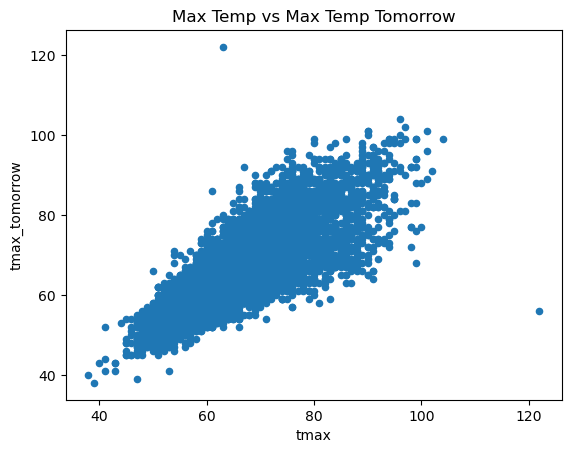

In [108]:
import pandas as pd

# Load weather data and fill in any missing values
weather = pd.read_csv('data/clean_weather.csv', index_col=0)
weather = weather.ffill()

weather.plot.scatter("tmax", "tmax_tomorrow", title="Max Temp vs Max Temp Tomorrow")

In [85]:
# Print the correlation matrix between the tmax and tmax_tomorrow columns. A perfect correlation would be +/-1.0, so this data is clearly not perfectly correlated.
print(weather.corr())    

                   tmax      tmin      rain  tmax_tomorrow
tmax           1.000000  0.615604 -0.219941       0.818561
tmin           0.615604  1.000000 -0.019546       0.585572
rain          -0.219941 -0.019546  1.000000      -0.211799
tmax_tomorrow  0.818561  0.585572 -0.211799       1.000000


c:\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


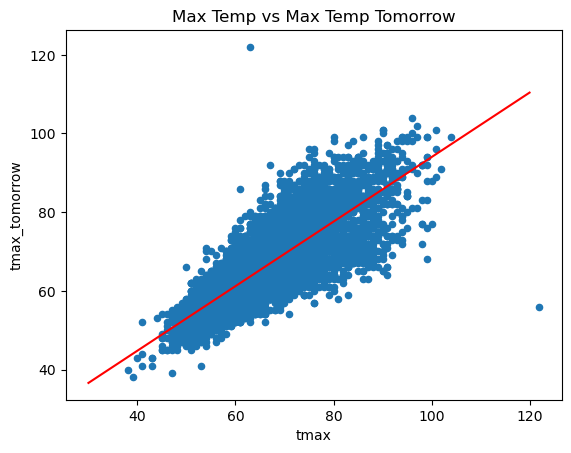

In [86]:
import matplotlib.pyplot as plt
weather.plot.scatter("tmax", "tmax_tomorrow", title="Max Temp vs Max Temp Tomorrow")

# Add a line of best fit to the scatter plot for a given x (tmax) and y (tmax_tomorrow) using the equation y = x*w1 + b
prediction = lambda x, w1=.82,b=11.99: x*w1+b
# Plot from bottom left to top right, with value predicitons for 30 and 120
plt.plot([30,120], [prediction(30), prediction(120)], color='red')

In [87]:
import numpy as np
# Calculate the mean squared error for the line of best fit

def mse(actual, predicted):
    return np.mean((actual - predicted)**2)

# Calculate the mean squared error for the line of best fit
print("MSE =",mse(weather.tmax_tomorrow, prediction(weather.tmax)))

# Clearly, this is the best that a linear regression model can do with this data. We want to use NN to improve the model as it will allow us to represent the non-linear relationship 
# between tmax and tmax_tomorrow.

MSE = 22.897335324598394


Key things that Neural Networks can do:
1. Adds a non linear transformation on top of the linear transformation (using activation functions)
2. Adds muldtiple layers, which can capture interactions between features (yhat = Wx + b)
3. Adds multiple hidden units, which have slightly different linear and non linear transformations

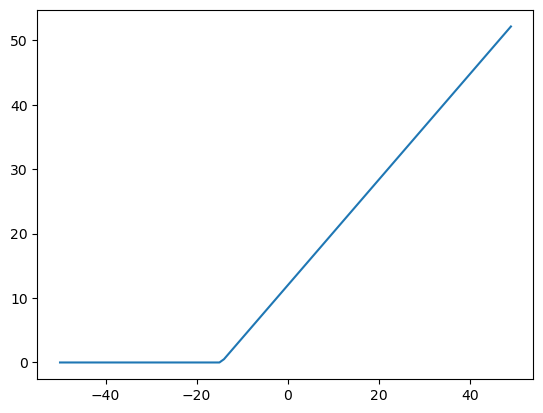

In [88]:
# ReLu activation function
def relu(x):
    return max(0,x)

temps = np.arange(-50, 50)
# If the temperature is below 0, the output is 0, else, the output is the temperature itself. This adds non-linearity to the model -> y = relu(x*w1 + b)
plt.plot(temps, [relu(x) for x in prediction(temps)])

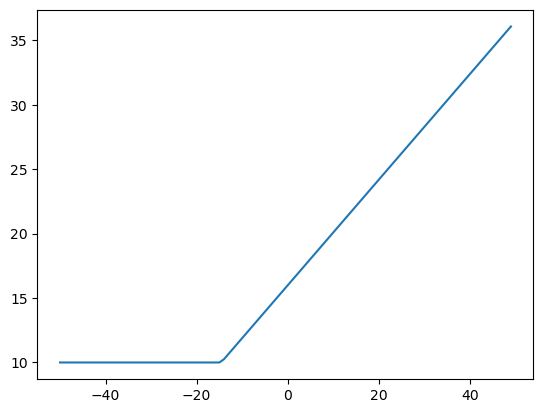

In [89]:
# Multiple layers: The output of one layer is the input to the next layer. This allows the model to learn more complex relationships between the input and output.
# i.e: y = w2*(relu(w1*x + b1)) + b2 where w1 and b1 are the weights and biases of the first layer, and w2 and b2 are the weights and biases of the second layer.

temps = np.arange(-50, 50)
layer1 = np.maximum(0,prediction(temps)) # ReLu applied to first layer of linear transformation to create non-linearity
layer2 = prediction(layer1, 0.5, 10) # Second layer of linear transformation

plt.plot(temps, layer2)
# We can see that we're now predicting 10 when the temperature is 0 based on our final bias term.

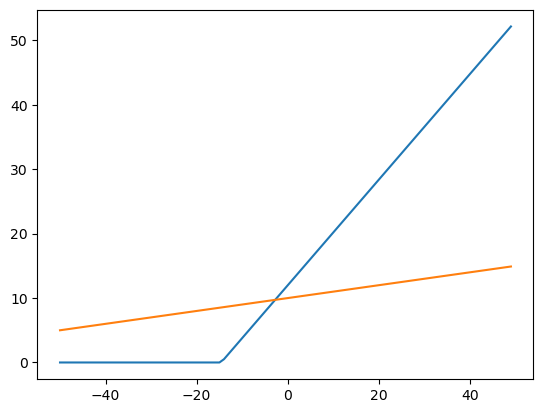

In [90]:
# Multiple hidden units
layer1_1 = np.maximum(0, prediction(temps)) # Default weight and bias for first hidden unit
layer1_2 = np.maximum(0, prediction(temps, 0.1, 10)) # Different weights and biases for second hidden unit

plt.plot(temps, layer1_1)
plt.plot(temps, layer1_2) # We can see that this weight and bias did not activate reLu at all based on having a really small weight and large bias.

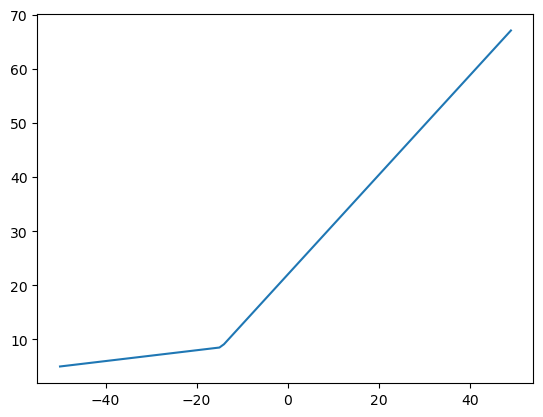

In [91]:
# Combine multiple hidden units
plt.plot(temps, layer1_1 + layer1_2) # We can see that the output of the two hidden units is the sum of their outputs.

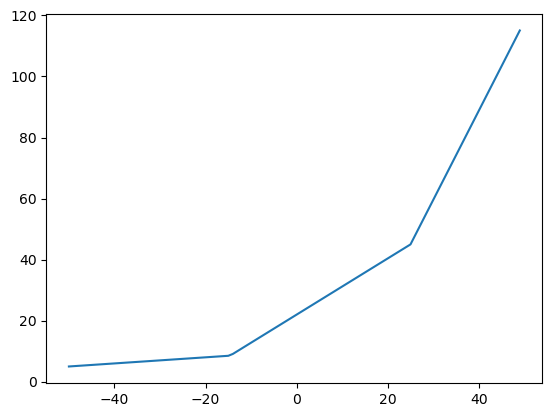

In [92]:
# As we add more hidden units with varying weights and biases, the relationship can grow in complexity
layer1_3 = np.maximum(0,prediction(temps, 2, -50))
plt.plot(temps, layer1_1 + layer1_2 + layer1_3)

# We can create an output layer (layer 2) that is a linear combination of the outputs of the hidden layers (layer 1)
# y = w3*[relu(w1*x + b1) + relu(w2*x + b2) + relu(w3*x + b3)] + b3

In [93]:
# Forward Pass - The process of calculating the output of a neural network for a given input, weights and biases

input = np.array([80, 90, 100, -20, -10]).reshape(-1,1) #5x1 -> reshape (row, column) allows you to specify -1 to automatically calculate the number of rows
l1_weights = np.array([0.81, 0.1]).reshape(1,-1) 
l1_biases = np.array([11.99, 10]).reshape(1,-1)

l1_output = np.maximum(0, np.dot(input, l1_weights) + l1_biases) # ReLu activation function applied to the linear transformation of the input
print(l1_output) # End up with a 5x2 matrix

[[76.79 18.  ]
 [84.89 19.  ]
 [92.99 20.  ]
 [ 0.    8.  ]
 [ 3.89  9.  ]]


In [94]:
# Add in second layer of weights and biases
l2_weights = np.array([0.5, 0.2]).reshape(-1,1)
l2_biases = np.array([5]).reshape(1,-1)

# Apply the second layer of weights and biases to the output of the first layer - linear transformation
l2_output = np.dot(l1_output, l2_weights) + l2_biases
print(l2_output) # End up with a 5x1 matrix

[[46.995]
 [51.245]
 [55.495]
 [ 6.6  ]
 [ 8.745]]


In [95]:
# Backward Pass (backpropogation) - The process of calculating the gradient of the loss function with respect to the weights and biases of the neural network

# If we don't have our weights and biases, we can use gradient descent to find the best weights and biases for our model.
def mse(actual, predicted):
    return (actual - predicted)**2
    
def mse_gradient(actual, predicted):
    # Since the gradient of mse is 2*(predicted-actual), we can drop the 2 as it's a constant and doesn't change the direction of the gradient
    return predicted-actual

# Example set of weather data
tmax = np.array([80, 90, 100, -20, -10]).reshape(-1,1)
tmax_tomorrow = np.array([83, 89, 95, -22, -9]).reshape(-1,1)

output_gradient = mse_gradient(tmax_tomorrow, l2_output)
l2_weights_gradient = np.dot(l1_output.T, output_gradient) # dL/dw2 = dy/dw2 * dL/dy --> since y = w2*relu(w1*x + b1) + b2, dy/dw2 = relu(w1*x + b1) which is the output of the first layer
l2_biases_gradient = np.mean(output_gradient) # dL/db2 = dy/db2 * dL/dy --> since y = w2*relu(w1*x + b1) + b2, dy/db2 = 1; dL/db2 = dL/dy
print(l2_weights_gradient, l2_biases_gradient)

[[-9574.3878]
 [-1767.03  ]] -13.383999999999997


In [96]:
learning_rate = 1e-5
print("Pre descent: ", l2_weights)
# Update the weights and biases using gradient descent
l2_weights = l2_weights - l2_weights_gradient*learning_rate
l2_biases = l2_biases - l2_biases_gradient*learning_rate
print("Post descent: ", l2_weights)

Pre descent:  [[0.5]
 [0.2]]
Post descent:  [[0.59574388]
 [0.2176703 ]]


In [97]:
# Now that we have our layer 2 gradients, lets get our layer 1 gradients
l1_output_gradient = np.dot(output_gradient, l2_weights.T) # dL/y1 = dy/dy1 * dL/dy --> since y = w2*y1 + b2, dy/dy1 = w2 * grad(Relu); dL/dw1 = dL/dy * w2 * grad(Relu)
l1_output_gradient[l1_output < 0] = 0 # ReLu gradient is 0 if the input is less than 0
print(l1_output_gradient)

l1_weights_gradient = np.dot(tmax.T, l1_output_gradient) # dL/dw1 = dy/dw1 * dL/dy1 --> since y = w1*x + b1, dy/dw1 = x;
l1_biases_gradient = np.mean(l1_output_gradient) # dL/db1 = dy/db1 * dL/dy1 --> since y = w1*x + b1, dy/db1 = 1;

print("Pre descent: ", l1_weights)
l1_weights = l1_weights - l1_weights_gradient*learning_rate
l1_biases = l1_biases - l1_biases_gradient*learning_rate
print("Post descent: ", l1_weights)

[[-21.44975833  -7.83721915]
 [-22.49231011  -8.21814218]
 [-23.5348619   -8.5990652 ]
 [ 17.03827491   6.22537058]
 [ 10.57147512   3.86255947]]
Pre descent:  [[0.81 0.1 ]]
Post descent:  [[0.87540255 0.1238965 ]]


In [120]:
# Let's put it all together and estimate tomorrow's max temperature using a neural network
import numpy as np
from sklearn.preprocessing import StandardScaler

predictors = ['tmax', 'tmin', 'rain']
target = 'tmax_tomorrow'

# Normalize data
scaler = StandardScaler()
weather[predictors] = scaler.fit_transform(weather[predictors])

# Split data into training, validation, and test sets
split_data = np.split(weather, [int(0.7*len(weather)), int(0.85*len(weather))])
(train_x, train_y), (val_x, val_y), (test_x, test_y) = [[d[predictors].to_numpy(), d[target].to_numpy()] for d in split_data]

# Reshape the target data
train_y = train_y.reshape(-1,1)
val_y = val_y.reshape(-1,1)
test_y = test_y.reshape(-1,1)

# Initialize weights and biases
def init_layers(inputs):
    layers = []
    for i in range(1,len(inputs)):
        layers.append([np.random.rand(inputs[i-1], inputs[i])/5 - 0.1, # Weights array scaled to be between -0.1 and 0.1 with shape (inputs[i-1], inputs[i]) 
                                                                       # no. of columns in prev layer by no. of columns in current layer
                       np.ones((1,inputs[i]))]) # Biases array initialized to 1
    return layers

layer_conf = [3,10,10,1] # 3 input features (predictors), 2 hidden layers with 10 hidden units each, and 1 output
layers = init_layers(layer_conf)

In [99]:
layers

[[array([[-0.04683171, -0.09187399,  0.0471197 ,  0.00870614, -0.04069896,
           0.01847619, -0.06899341, -0.07830238,  0.02730239,  0.01996575],
         [-0.07358389,  0.01177445,  0.01253273, -0.03946108,  0.08692133,
           0.03877544, -0.03315102, -0.08358312, -0.06698391, -0.01039269],
         [ 0.04119966,  0.03836001, -0.0639899 ,  0.03758877, -0.06861791,
          -0.08547594,  0.0554395 , -0.03461599,  0.09480619,  0.06678746]]),
  array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])],
 [array([[-0.09544814, -0.0493713 ,  0.0371535 , -0.01460626,  0.00471483,
           0.09995188, -0.02504427, -0.02454587,  0.00292758,  0.08997787],
         [-0.06960028, -0.03566714, -0.05995642,  0.01356191, -0.05729504,
           0.09388228,  0.02718565, -0.08447032,  0.06680774,  0.0924175 ],
         [-0.06167065, -0.05472831, -0.0543751 , -0.04600411,  0.05504842,
          -0.01066982,  0.05208734, -0.067403  , -0.02381136, -0.01966462],
         [-0.0548346 ,  0.00765844, -0

In [100]:
# Forward pass
def forward(batch, layers):
    hidden = [batch.copy()]
    for i in range(len(layers)):
        batch = np.matmul(batch, layers[i][0]) + layers[i][1] # Linear transformation
        if i < len(layers) - 1:
            batch = np.maximum(0, batch) # ReLu activation function if not the output layer
        hidden.append(batch.copy())
    return batch, hidden # Batch will be 1 value for each row (predictions), hidden will be the output of each layer for each row

In [101]:
# Loss function
def mse(actual, predicted):
    return (actual - predicted)**2
    
def mse_gradient(actual, predicted):
    return predicted-actual

In [109]:
# Backward pass
def backward(layers, hidden, grad, learning_rate):
    for i in range(len(layers)-1, -1, -1): # Loop through layers in reverse order
        if i != len(layers)-1:
            grad = np.multiply(grad, np.heaviside(hidden[i+1], 0)) # Multiply the gradient by the Heaviside step function (ReLu gradient); if we're not at the last layer, we have reLu to undo
        w_grad = hidden[i].T @ grad # dL/dw = dy/dw * dL/dy
        b_grad = np.mean(grad, axis=0)
        layers[i][0] = layers[i][0] - w_grad*learning_rate # Update weights
        layers[i][1] = layers[i][1] - b_grad*learning_rate # Update biases

        grad = grad @ layers[i][0].T # Propogate the gradient back through the network as we update the weights
    return layers

In [132]:
# Training loop
from statistics import mean

learning_rate = 1e-6
epochs = 10
batch_size = 8
layer_conf = [3,10,10,1] # 3 input features (predictors), 2 hidden layers with 10 hidden units each, and 1 output

layers = init_layers(layer_conf)

for epoch in range(epochs):
    epoch_loss = []
    for i in range(0, train_x.shape[0], batch_size):
        batch_x = train_x[i:(i+batch_size)]
        batch_y = train_y[i:(i+batch_size)]
        
        # Forward pass step
        predictions, hidden = forward(batch_x, layers)
        # Calculate loss and gradient
        loss = mse_gradient(batch_y, predictions)
        epoch_loss.append(np.mean(loss**2))
        # Backward pass step
        layers = backward(layers, hidden, loss, learning_rate)

    valid_preds, _ = forward(val_x, layers) # Forward pass on validation set to see how well the model is doing for each epoch
    print (f"Epoch {epoch+1}: Training MSE = {mean(epoch_loss)}, Validation Loss = {np.mean(mse(val_y, valid_preds))}")

Epoch 1: Training MSE = 3364.8763204924235, Validation Loss = 1834.2466809743917
Epoch 2: Training MSE = 388.2170889434792, Validation Loss = 26.990285044570893
Epoch 3: Training MSE = 23.4576384588293, Validation Loss = 21.400642995598737
Epoch 4: Training MSE = 22.46844708129027, Validation Loss = 20.890763838452823
Epoch 5: Training MSE = 22.187284893966137, Validation Loss = 20.788440138006973
Epoch 6: Training MSE = 22.114449888504595, Validation Loss = 20.773759182771688
Epoch 7: Training MSE = 22.094744964432955, Validation Loss = 20.77546524686166
Epoch 8: Training MSE = 22.088211587310795, Validation Loss = 20.778721997606
Epoch 9: Training MSE = 22.085432195893944, Validation Loss = 20.78126232842669
Epoch 10: Training MSE = 22.083679755167395, Validation Loss = 20.783057560690587


In [122]:
# Measure against test set using trained model (layers)
predictions, _ = forward(test_x, layers)
print(np.mean(mse(test_y, predictions)))

22.03309046110957
